In [4]:
import numpy as np
from scipy import optimize
from numba import vectorize, float32, float64
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use(['science','notebook'])

import sys
sys.path.insert(0, '../src/pydftlj/')
from dft3d import Gradient
from dft3d import dft3d as dft
from eos import LJEOS 

from pymatgen.core import Structure
from pymatgen.analysis import structure_matcher

# Author: Elvis do A. Soares
# Github: @elvissoares
# Date: 2023-03-01

In [5]:
kB = 1.380649e-23 # J/K
Rconst = 0.082057366080960 # Gas constant
NA = 6.022e23 # Avogadro number

## Solid CIF file Information

In [14]:
structure_name = 'ZIF-8'
structure = Structure.from_file('../structures/'+structure_name+'.cif')
structure.make_supercell(2)
print(structure.get_space_group_info())
print('formula:  ', structure.formula)
print('num_sites:', structure.num_sites)

('P1', 1)
formula:   Zn48 H288 C288 N192
num_sites: 816


In [15]:
coordinates = structure.cart_coords.T
L = np.array([l/2 for l in structure.lattice.lengths])
print('Cell dimensions: ', L)
Vcell = L[0]*L[1]*L[2]
print('Cell volume: ', Vcell)

Cell dimensions:  [14.7363 14.7801 14.764 ]
Cell volume:  3215.6580733693204


In [16]:
coordinates[0].max()

25.529661358548516

In [17]:
coordinates[0].min()

-11.550308700980825

# Force Field for solid-fluid interaction

In [18]:
forcefield_name = 'DREIDING'
forcefield = pd.read_csv('../parameters/'+forcefield_name+'-forcefield.dat',delim_whitespace=True)
forcefield

,atom,sigma/AA,epsilon/kB,mass/u
0,H,2.84642,7.64893,1.00784
1,C,3.47299,47.85620,12.01070
2,N,3.26256,38.94920,14.00670
3,O,3.03315,48.15810,15.99900
4,Cu,3.11000,2.51800,63.54600
5,Zn,4.04468,27.67710,65.38000


# Fluid Information

In [19]:
epsilonff = 10.22 # kelvin
sigmaff = 2.58 # angstrom
mff = 4.0026

# Create the DFT object

In [20]:
Ngrid = 64

In [21]:
DFT = dft(gridsize=np.array([Ngrid,Ngrid,Ngrid]),fmtmethod='WBI',ljmethod='MMFA')

In [22]:
DFT.Set_Geometry(L)

In [23]:
DFT.GetSystemInformation()

============== The DFT 3D for LJ fluids ==============
Methods:
FMT : WBI - antisymmetrized
Attractive : MMFA
The grid is [64 64 64]
--- Geometry properties ---
Lx = 14.7363  A
Ly = 14.780100000000001  A
Lz = 14.764  A
Vol = 3215.6580733693204  A³


In [24]:
DFT.Set_FluidProperties(sigma=sigmaff,epsilon=epsilonff)

In [25]:
DFT.GetFluidInformation()

--- Fluid properties ---
epsilon/kB = 10.22  K
sigma = 2.58  A


## Defining the Temperature

In [26]:
kT = 300.0 # kelvin 

DFT.Set_Temperature(kT)

In [27]:
DFT.GetFluidTemperatureInformation()

Temperature = 300.0  K
Baker-Henderson diameter = 2.159  A


## Generating the External Potential

In [29]:
sigmasf = np.zeros(structure.num_sites)
epsilonsf = np.zeros(structure.num_sites)
mss = 0.0

# Lorentz-Berthelot combination rule
for i, site in enumerate(structure):
    sigmasf[i] = 0.5*(sigmaff+forcefield["sigma/AA"][forcefield["atom"]==site.species_string])
    epsilonsf[i] = np.sqrt(epsilonff*forcefield["epsilon/kB"][forcefield["atom"]==site.species_string])
    mss = mss + float(forcefield["mass/u"][forcefield["atom"]==site.species_string])
    
mss = mss/8

In [30]:
@vectorize
def ljpotential(r,eps,sigma):
    return 4*eps*((sigma/r)**(12)-(sigma/r)**(6))

In [31]:
DFT.x

array([ 0.        ,  0.23390952,  0.46781905,  0.70172857,  0.9356381 ,
        1.16954762,  1.40345714,  1.63736667,  1.87127619,  2.10518571,
        2.33909524,  2.57300476,  2.80691429,  3.04082381,  3.27473333,
        3.50864286,  3.74255238,  3.9764619 ,  4.21037143,  4.44428095,
        4.67819048,  4.9121    ,  5.14600952,  5.37991905,  5.61382857,
        5.8477381 ,  6.08164762,  6.31555714,  6.54946667,  6.78337619,
        7.01728571,  7.25119524,  7.48510476,  7.71901429,  7.95292381,
        8.18683333,  8.42074286,  8.65465238,  8.8885619 ,  9.12247143,
        9.35638095,  9.59029048,  9.8242    , 10.05810952, 10.29201905,
       10.52592857, 10.7598381 , 10.99374762, 11.22765714, 11.46156667,
       11.69547619, 11.92938571, 12.16329524, 12.39720476, 12.63111429,
       12.86502381, 13.09893333, 13.33284286, 13.56675238, 13.8006619 ,
       14.03457143, 14.26848095, 14.50239048, 14.7363    ])

In [32]:
%%time

Vext = np.zeros_like(DFT.rho)

X,Y,Z = np.meshgrid(DFT.x,DFT.y,DFT.z,indexing ='ij')
for i, site in enumerate(structure):
    R = np.sqrt((X-structure.cart_coords[i,0]+L[0]/2)**2 + (Y-structure.cart_coords[i,1]+L[1]/2)**2 + (Z-structure.cart_coords[i,2]+L[2]/2)**2)
    Vext[:] += ljpotential(R,epsilonsf[i],sigmasf[i])

del X,Y,Z,R

# np.save('externalpotential-CH4-MOF5-DREIDING-T='+str(kT)+'K-'+str(dft.gridsize)+'.npy',Vext)
# Vext[:] = np.load('externalpotential-CH4-MOF5-DREIDING-T='+str(kT)+'K-'+str(dft.gridsize)+'.npy')

DFT.Set_External_Potential(Vext)

CPU times: user 3.2 s, sys: 9.54 ms, total: 3.21 s
Wall time: 3.21 s


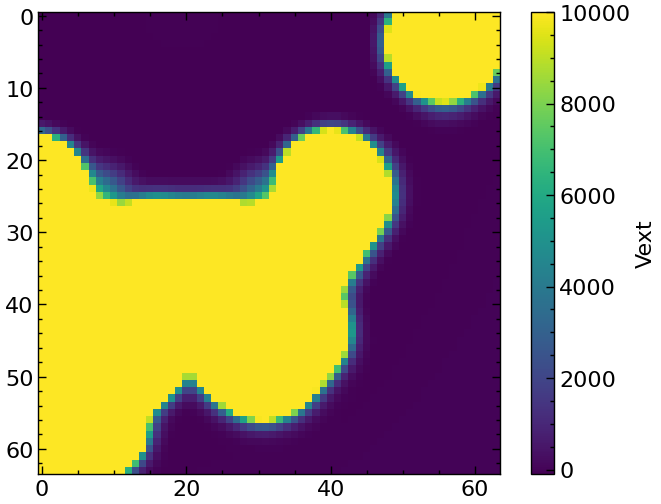

In [34]:
plt.imshow(DFT.Vext[:,:,0], cmap='viridis',vmin=-1e2,vmax=1e4)
plt.colorbar(label='Vext')
plt.show()

In [23]:
Vextpos = Vext.copy()
# Vextpos[Vextpos< 0.0] = 0.0

In [24]:
Vpore = np.sum(np.exp(-DFT.beta*Vextpos))*DFT.dV

In [25]:
Vpore/Vcell

0.8031152018420536

In [97]:
# helium_void_fraction = Vpore/Vcell
helium_void_fraction = 0.815

In [89]:
Vpore = helium_void_fraction*Vcell

In [90]:
Nexcarray = Nadsarray - rhobarray*Vpore
Mexcarray = Nexcarray*mff

NameError: name 'Nadsarray' is not defined

In [ ]:
import pandas as pd
df = pd.DataFrame()